# Test Binary Mask

For training, we will store the relative path information for each image and its masks within a dataframe with the following structure:

|   images                                                                    |   masks                                               |   train  |
|-----------------------------------------------------------------------------|-------------------------------------------------------|----------|
|   ./data/images_stacked_channels/mx85-nd-acqusition-0-stacked-channels.tif  |   ./data/masks/mx85-nd-acqusition-0-ground-truth.tif  |   TRUE   |
|   ./data/images_stacked_channels/mx85-nd-acqusition-1-stacked-channels.tif  |   ./data/masks/mx85-nd-acqusition-1-ground-truth.tif  |   TRUE   |
|   ./data/images_stacked_channels/mx85-nd-acqusition-8-stacked-channels.tif  |   ./data/masks/mx85-nd-acqusition-8-ground-truth.tif  |   FALSE  |

In [1]:

import os
os.chdir("../") # Root of repo
#os.chdir("/Users/llanos/Documents/UNet_3D_C_elegans/") # Root of repo
import pandas as pd
import unet.utils.data_utils as utils
from unet.utils.load_data import CElegansDataset
from unet.networks.unet3d import UNet3D
from unet.networks.unet3d import SingleConv
import sklearn.model_selection
from torch.utils.data import DataLoader
from unet.utils.loss import WeightedBCELoss, WeightedBCEDiceLoss
import unet.augmentations.augmentations as aug
import torch
from unet.utils.trainer import RunTraining

/opt/conda/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
print(os.getcwd())

/workspace


In [3]:
# Set parameters
# Here we can easily change data parameters and model hyperparameters

params = {
    "Normalize": {"per_channel": True},
    "RandomContrastBrightness": {"p": 0.5},
    "Flip": {"p": 0.5},
    "RandomRot90": {"p": 0.5, "channel_axis": 0},
    "RandomGuassianBlur": {"p": 0.5},
    "RandomGaussianNoise": {"p": 0.5},
    "RandomPoissonNoise": {"p": 0.5},
    "ElasticDeform": {"sigma":10, "p":0.5, "channel_axis": 0, "mode":"mirror"},
    "LabelsToEdges": {"connectivity": 2, "mode":"thick"},
    "EdgeMaskWmap": {"edge_multiplier":2, "wmap_multiplier":1, "invert_wmap":True},
    "LabelsToEdgesAndBinary": {"connectivity": 2, "mode": "thick","blur":2},
    "BinaryMaskWmap": {"edge_multiplier":2, "wmap_multiplier":1, "invert_wmap":True},
    "BlurMasks": {"sigma": 2},
    "ToTensor": {},
    "batch_size": 1,
    "epochs": 2,
    "val_split": 0.2,
    "patch_size": (24, 200, 200),
    "create_wmap": True, ##
    "lr": 1e-2,
    "weight_decay": 1e-5,
    "in_channels": 1,
    "out_channels": 1,
    "scheduler_factor": 0.2,
    "scheduler_patience": 20,
    "scheduler_mode": "min",
    "loss_function": WeightedBCEDiceLoss,
    # "targets": [["image"], ["mask"]]
    "targets": [["image"], ["mask"], ["weight_map"]]
}

In [4]:
print(os.getcwd())

/workspace


In [5]:
#source_data = pd.read_csv("/Users/llanos/Documents/UNet_3D_C_elegans/data/data_stacked_channels_training.csv")[0:2]
source_data = pd.read_csv("./data/data_stacked_channels_training.csv")[0:2]


#isExist = os.path.exists('./data/data_stacked_channels_training.csv')
#print(isExist)

In [6]:
# Create patches of the dataset
# This is performed prior to training since weight-map generation online at train time is 
# computationally slow
utils.create_patch_dataset(source_data, patch_size=params["patch_size"], create_wmap=params["create_wmap"])

# Load the patch dataframe
training_data = pd.read_csv("training_data.csv")

# Create the train/val split
train_dataset, val_dataset = sklearn.model_selection.train_test_split(
        training_data, test_size=params["val_split"]
        )

# Define the augmentations for training and validation
train_transforms = [
    aug.Normalize(**params["Normalize"]), 
    aug.RandomContrastBrightness(**params["RandomContrastBrightness"]),
    aug.Flip(**params["Flip"]),
    aug.RandomRot90(**params["RandomRot90"]),
    aug.RandomGuassianBlur(**params["RandomGuassianBlur"]),
    aug.RandomGaussianNoise(**params["RandomGaussianNoise"]),
    aug.RandomPoissonNoise(**params["RandomPoissonNoise"]),
    aug.ElasticDeform(**params["ElasticDeform"]), #last transform shape: (1, 24, 200, 200)
    #aug.LabelsToEdges(**params["LabelsToEdges"]),
    aug.LabelsToEdgesAndBinary(**params["LabelsToEdgesAndBinary"]),
    aug.BinaryMaskWmap(**params["BinaryMaskWmap"]),
    #aug.ToTensor()
]

val_transforms = [
    aug.Normalize(**params["Normalize"]),
    aug.LabelsToEdges(**params["LabelsToEdges"]),
    aug.EdgeMaskWmap(**params["EdgeMaskWmap"]),
    aug.BlurMasks(**params["BlurMasks"]),
    aug.ToTensor()
]

#print(train_transforms['image'].shape)
train_ds = CElegansDataset(data_csv=train_dataset, transforms=train_transforms, targets=params["targets"], train_val="train")

#print(train_transforms['image'].shape)
output = train_ds[0]        # o cualquier índice que quieras inspeccionar
image = output['mask']     # esto es un numpy array
print(f'last transform shape: {image.shape}')
#val_ds = CElegansDataset(data_csv=val_dataset, transforms=val_transforms, targets=params["targets"], train_val="val")


(1, 113, 1024, 584) (1, 113, 1024, 584) (1, 113, 1024, 584)
(1, 100, 1024, 1024) (1, 100, 1024, 1024) (1, 100, 1024, 1024)
labels shape: (1, 24, 200, 200)
this label patch is not blank
cell_edges shape: (24, 200, 200)
foreground shape: (24, 200, 200)
labels function (24, 200, 200) (2, 24, 200, 200)
wmap shape (1, 24, 200, 200) mask shape (1, 24, 200, 200)
(1, 24, 200, 200) (1, 24, 200, 200)
last transform shape: (1, 24, 200, 200)


In [9]:
output = train_ds[20]        # o cualquier índice que quieras inspeccionar
image = output["weight_map"]     # esto es un numpy array
print(f'last transform shape: {image.shape}')


labels shape: (1, 24, 200, 200)
this label patch is not blank
cell_edges shape: (24, 200, 200)
foreground shape: (24, 200, 200)
labels function (24, 200, 200) (2, 24, 200, 200)
wmap shape (1, 24, 200, 200) mask shape (1, 24, 200, 200)
(1, 24, 200, 200) (1, 24, 200, 200)
last transform shape: (1, 24, 200, 200)


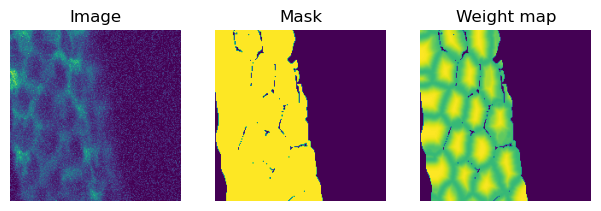

In [10]:
import matplotlib.pyplot as plt 
fig, ax = plt.subplots(1, 3, figsize=(7.5, 5))
z = 20
#ax[0,0].imshow(output["image"][0,z,...])
#ax[0,1].imshow(output["mask"][z,...])
#ax[0,2].imshow(output["weight_map"][z,...])
ax[0].imshow(output["image"][0,z,...])
ax[1].imshow(output["mask"][0,z,...])
ax[2].imshow(output["weight_map"][0,z,...])

ax[0].set_title("Image")
ax[1].set_title("Mask")
ax[2].set_title("Weight map")


for _ax in ax.flatten():
    _ax.axis("off") 
